In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import math

import pickle as pkl
from sklearn.preprocessing import minmax_scale,scale

import squidpy.gr as sqgr
import diffxpy.api as de

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.patches import Patch
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
import scipy.stats as stats

from scipy.stats import binom_test
from statsmodels.stats.multitest import multipletests

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster,leaves_list
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from scipy.sparse import csr_matrix

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

In [3]:
ro.r('library("hypeR")')
ro.r("source(paste(Sys.getenv('WSCL'),'diabetes_analysis/data_exploration/','helper_hypeR.R',sep=''))")
ro.r('library(pvclust)')

array(['pvclust', 'visNetwork', 'msigdbr', 'hypeR', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U10')

In [4]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_save='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/moransi/sfintegrated/'
compass_dir='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/compass/data_integrated_analysed_beta_v1s1_sfintegrated/'
compass_res_suffix='results_recon3/'
compass_programs_dir=compass_dir+compass_res_suffix+'analysis/'

In [5]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [6]:
path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad'

'/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad'

In [7]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
adata_rn_b.shape

(102143, 30672)

In [7]:
# Load GP info
genes_hc=pd.read_table(path_save+'gene_hc_t'+str(2.4)+'.tsv',sep='\t',index_col=0)

## Define cell clusters
Define cell clusters based on gene programs: use HC on programs.
- Score each cell for each program
- Make leiden-based fine pseudobulk
- Cluster (HC) pseudobulk based on program scores (also try out Leiden, but HC performed better)
- Asign each cell to cluster based on pseudobulk-based clusters


In [16]:
# Gene cluster scores 
gene_cl='hc'
adata_rn_b.obs.drop([col for col in adata_rn_b.obs.columns 
                     if 'gene_score_cluster_'+gene_cl in col],axis=1,inplace=True)
for ct in sorted(genes_hc[gene_cl].unique()):
    score_name='gene_score_cluster_'+gene_cl+str(ct)
    sc.tl.score_genes(adata_rn_b, 
                      gene_list=genes_hc.index[genes_hc[gene_cl]==ct], 
                     score_name=score_name, use_raw=False)
    adata_rn_b.obs[score_name+'_scaled']=minmax_scale(adata_rn_b.obs[score_name])

In [11]:
# Make pseudobulk for clustering and plotting
# Mean within clusters of scaled gene programs
pseudobulk_scores=adata_rn_b.obs[[col for col in adata_rn_b.obs.columns
               if 'gene_score_cluster_hc' in col and '_scaled' in col]+['leiden_r20']
              ].groupby('leiden_r20').mean()
# rename columns to be shorter
pseudobulk_scores.columns=[col.replace('gene_score_cluster_hc','').replace('_scaled','')
                           for col in pseudobulk_scores.columns]
adata_pb_scores=anndata.AnnData(pseudobulk_scores)

In [10]:
color_list=['tab:blue',  'tab:orange','tab:green','tab:red', 'tab:purple',
                'tab:brown','tab:pink', 'tab:gray', 'tab:olive','tab:cyan',
                'lightsteelblue','bisque','limegreen','lightcoral','plum',
                'peru','pink','darkgrey','yellowgreen','paleturquoise','yellow','black',
                'gold','brown','navy','forestgreen','lime','lightsalmon','teal','olive']

In [13]:
adata_pb_scores.uns['cl_colors']=color_list

### Leiden

In [13]:
sc.pp.neighbors(adata_pb_scores,n_pcs=0)

In [22]:
sc.tl.leiden(adata_pb_scores,resolution=1.5)

In [23]:
# Add cl info to adata
adata_rn_b.obs['leiden_programs']=[int(adata_pb_scores.obs.at[cl,'leiden'] )
                               for cl in adata_rn_b.obs['leiden_r20']]
adata_rn_b.obs['leiden_programs']=pd.Categorical(adata_rn_b.obs['leiden_programs'], 
                      categories=sorted(adata_rn_b.obs['leiden_programs'].unique()),
                      ordered=True)
adata_rn_b.uns['leiden_programs_colors']=color_list

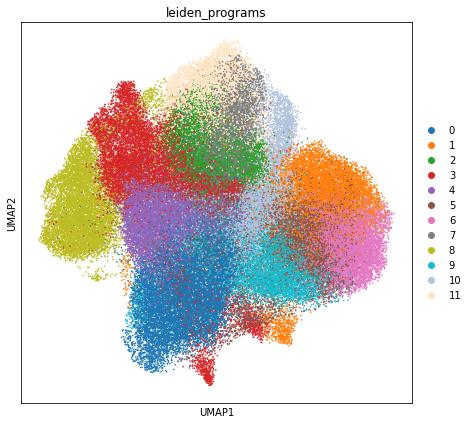

In [24]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_rn_b,color='leiden_programs',s=10)

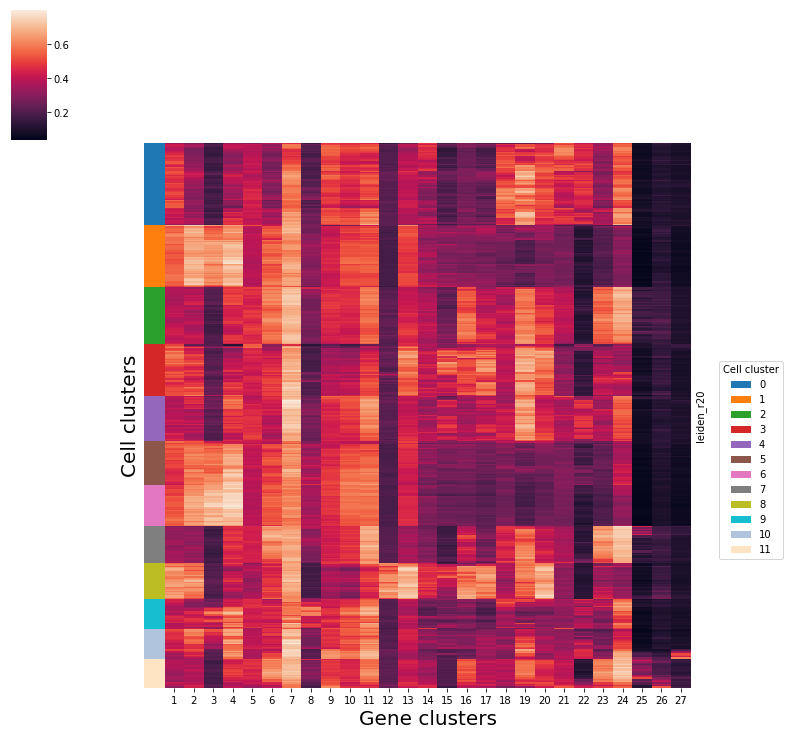

In [25]:
# Prepare some data for gene clusters heatmap
# Which clustering to show
cell_clustering='leiden'

# cell clustr anno
cell_cl_list=[adata_pb_scores.uns['cl_colors'][idx] for idx,cl in 
         enumerate(adata_pb_scores.obs[cell_clustering].cat.categories)
         for cell in adata_pb_scores.obs_names[adata_pb_scores.obs[cell_clustering]==cl]]

x_temp=adata_pb_scores.to_df()
# Order within cell clusters
cell_list= h.opt_order_withincl(x_temp,adata_pb_scores.obs[cell_clustering])

fg=sb.clustermap(x_temp.loc[cell_list,:], 
                row_colors=cell_cl_list,
              col_cluster=False,row_cluster=False,
             xticklabels=True, yticklabels=False)
 # Adds block annotation titles as axis labels
fg.ax_row_colors.set_ylabel('Cell clusters',fontsize=20)
fg.ax_heatmap.set_xlabel('Gene clusters',fontsize=20)
fg.ax_row_colors.yaxis.set_label_position('left') 
# legend for cell clusters
handles = [Patch(facecolor=c) for c in adata_pb_scores.uns['cl_colors']]
plt.legend(handles, adata_pb_scores.obs[cell_clustering].cat.categories, title='Cell cluster',
           bbox_to_anchor=(1.1, 0.5), bbox_transform=plt.gcf().transFigure)

C: Leiden does not work very well. Many small clusters of single programs are missed and some large clusters are split up.

### HC

In [26]:
# Compute hc
dist_cell=pdist(adata_pb_scores.X,metric='correlation')
# If large data do not use Ward as too slow on this N of elements - centroid
hc_cell=linkage(dist_cell, method='ward',  optimal_ordering=True)

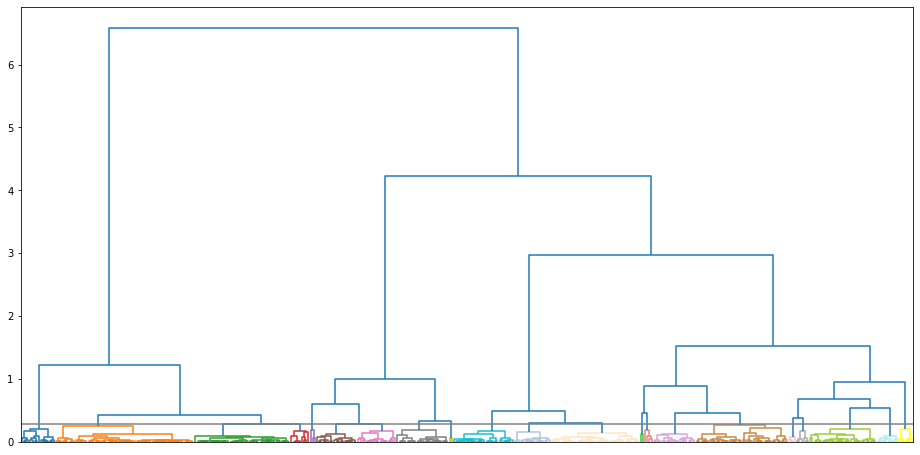

In [29]:
# Plot dendrogram
rcParams['figure.figsize']=(16,8)
hierarchy.set_link_color_palette(color_list)
cut_thresh_cell=0.28
dend_cell=dendrogram(hc_cell,color_threshold=cut_thresh_cell,no_labels=True)
plt.axhline(cut_thresh_cell,c='gray')

In [30]:
# Extract clusters at selected cutting threshold
adata_pb_scores.obs['hc']=fcluster(hc_cell,t=cut_thresh_cell,criterion='distance')
# Sort categories to match colors
adata_pb_scores.obs['hc']=pd.Categorical(adata_pb_scores.obs['hc'], 
                      categories=sorted(adata_pb_scores.obs['hc'].unique()),
                      ordered=True)
print('N cell clusters:',adata_pb_scores.obs['hc'].nunique())

N cell clusters: 21


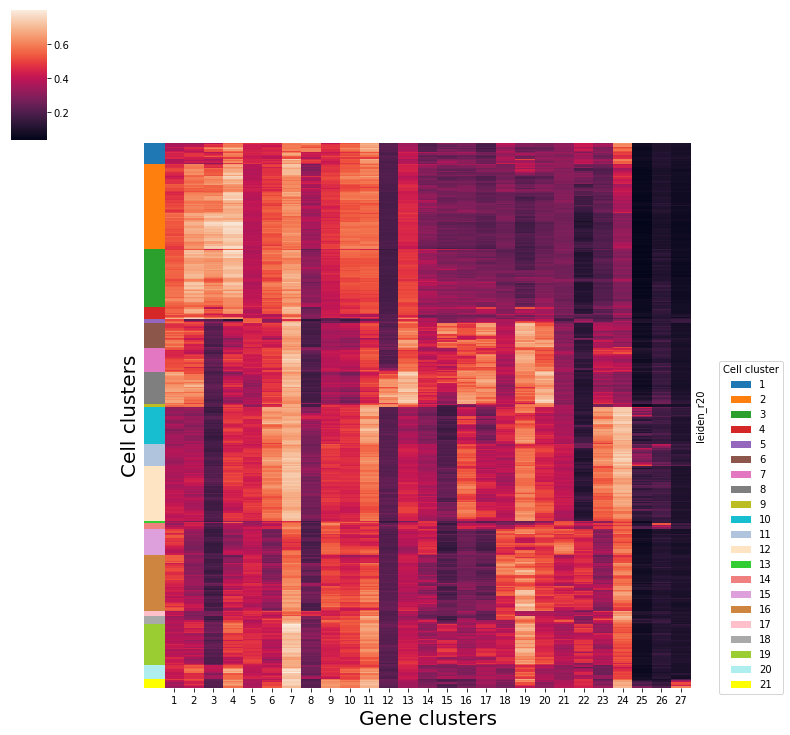

In [31]:
# Prepare some data for gene clusters heatmap
# Which clustering to show
cell_clustering='hc'

# cell clustr anno
cell_cl_list=[adata_pb_scores.uns[cell_clustering+'_colors'][idx] for idx,cl in 
         enumerate(adata_pb_scores.obs[cell_clustering].cat.categories)
         for cell in adata_pb_scores.obs_names[adata_pb_scores.obs[cell_clustering]==cl]]

x_temp=adata_pb_scores.to_df()
# Order within cell clusters
cell_list= h.opt_order_withincl(x_temp,adata_pb_scores.obs[cell_clustering])

fg=sb.clustermap(x_temp.loc[cell_list,:], 
                row_colors=cell_cl_list,
              col_cluster=False,row_cluster=False,
             xticklabels=True, yticklabels=False)
 # Adds block annotation titles as axis labels
fg.ax_row_colors.set_ylabel('Cell clusters',fontsize=20)
fg.ax_heatmap.set_xlabel('Gene clusters',fontsize=20)
fg.ax_row_colors.yaxis.set_label_position('left') 
# legend for cell clusters
handles = [Patch(facecolor=c) for c in adata_pb_scores.uns[cell_clustering+'_colors']]
plt.legend(handles, adata_pb_scores.obs[cell_clustering].cat.categories, title='Cell cluster',
           bbox_to_anchor=(1.1, 0.5), bbox_transform=plt.gcf().transFigure)

Potential limitations:

C: Some cells high in specific program were at certain resolutions split up due to small variations in a larger numnber of other programs that are more similar. 

C: It is possible that clustering across all programs would lead to noise from lowly-expressed programs when we are actually more interested in which programs are "up" in each cell (easier to interpret than differences in GPs with relatively low values).

C: It may be beneficial to instead of correlations use euclidean distance, as it may help to better resolve low quality populations. However, correlations otherwise work well for other clusters.

In [32]:
# Add cl info to adata
adata_rn_b.obs['hc_programs']=[int(adata_pb_scores.obs.at[cl,'hc'] )
                               for cl in adata_rn_b.obs['leiden_r20']]
adata_rn_b.obs['hc_programs']=pd.Categorical(adata_rn_b.obs['hc_programs'], 
                      categories=sorted(adata_rn_b.obs['hc_programs'].unique()),
                      ordered=True)
adata_rn_b.uns['hc_programs_colors']=color_list

## Analyse cell clusters

Number of cells per cell group

In [135]:
adata_rn_b.obs.hc_programs.value_counts()

2     13702
16    10058
12     8812
3      8619
8      8152
10     7469
19     7209
6      6875
15     5618
11     4470
1      4031
7      3896
21     2913
4      2649
20     2120
5      1125
17     1112
14      986
13      956
18      877
9       494
Name: hc_programs, dtype: int64

### GP activity

GP scores across cell clusters. GP scores were sclaed accross cells and averaged within cell clusters.

<AxesSubplot:ylabel='hc_programs'>

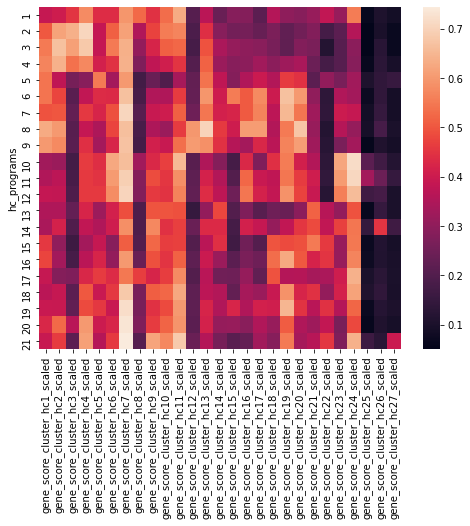

In [167]:
fig,ax=plt.subplots(figsize=(adata_pb_scores.shape[1]*0.3,
                             adata_rn_b.obs['hc_programs'].nunique()*0.3))
sb.heatmap(adata_rn_b.obs.groupby('hc_programs'
             )[['gene_score_cluster_hc'+col+'_scaled' 
                for col in adata_pb_scores.var_names]].mean())

Same as above, but computing cell cluster scores on non-normalised gene program scores, followed by normalisation across cell clusters,

<AxesSubplot:ylabel='hc_programs'>

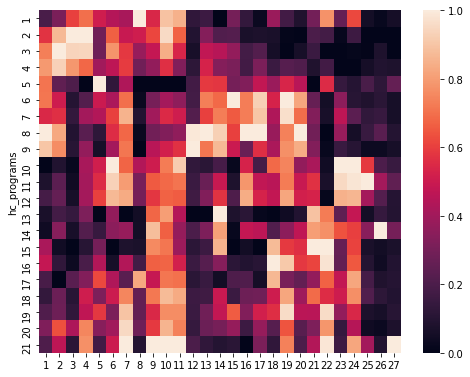

In [11]:
# Make pseudobulk
# Mean within beta clusters of gene programs
pseudobulk_gp_scaled=adata_rn_b.obs[[col for col in adata_rn_b.obs.columns
               if 'gene_score_cluster_hc' in col and '_scaled' not in col]+['hc_programs']
              ].groupby('hc_programs').mean()
# Scale
pseudobulk_gp_scaled=pd.DataFrame(minmax_scale(pseudobulk_gp_scaled),
                               index=pseudobulk_gp_scaled.index,columns=pseudobulk_gp_scaled.columns)
# rename columns to be shorter
pseudobulk_gp_scaled.columns=[col.replace('gene_score_cluster_hc','')
                           for col in pseudobulk_gp_scaled.columns]
# Plot
fig,ax=plt.subplots(figsize=(pseudobulk_gp_scaled.shape[1]*0.3,
                             pseudobulk_gp_scaled.shape[0]*0.3))
sb.heatmap(pseudobulk_gp_scaled)

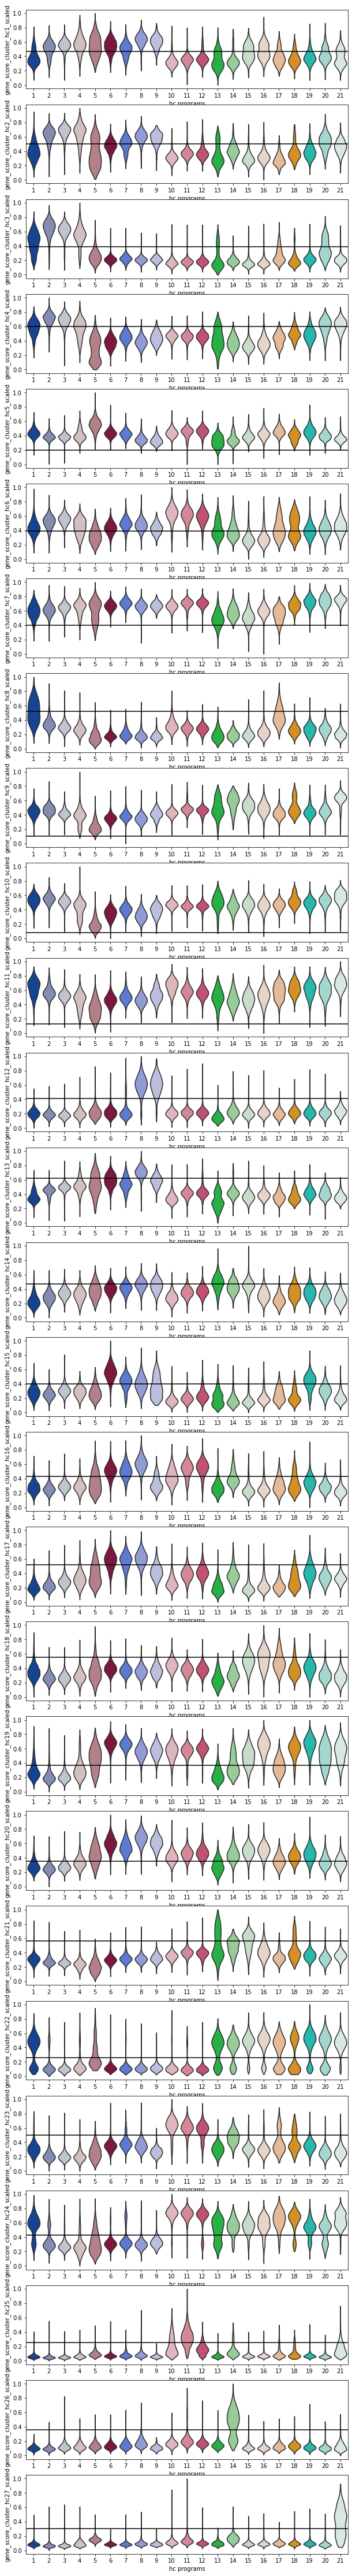

In [170]:
# Plot distn of scores across clusters
# needs code from below about high/low assignment to draw lines
cols=[col for col in adata_rn_b.obs.columns 
      if 'gene_score_cluster_hc' in col and '_scaled'  in col]
fig,ax=plt.subplots(len(cols),1,figsize=(10,len(cols)*3))
for idx,col in enumerate(cols):
    sc.pl.violin(adata_rn_b,groupby='hc_programs',keys=col,
                 stripplot=False,ax=ax[idx],show=False)
    # Needs threshold assignment from below
    ax[idx].axhline(thresholds[col.replace('gene_score_cluster_hc','').replace('_scaled','')],
                    c='k')

### Cell embedding

Cell clusters on UMAP

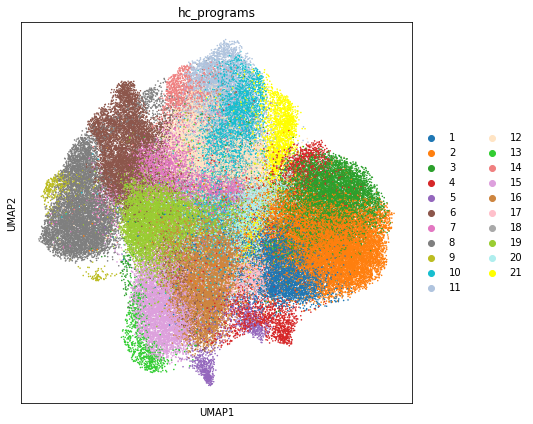

In [33]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_rn_b,color='hc_programs',s=10)

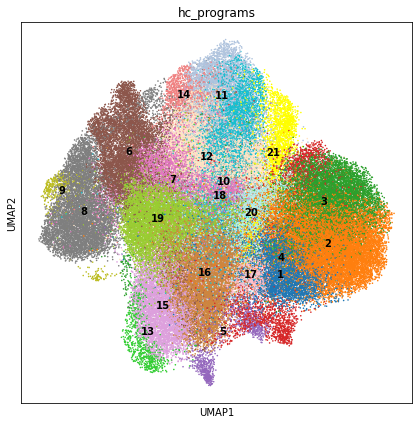

In [177]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_rn_b,color='hc_programs',s=10,legend_loc='on data')

Cluster location on UMAP

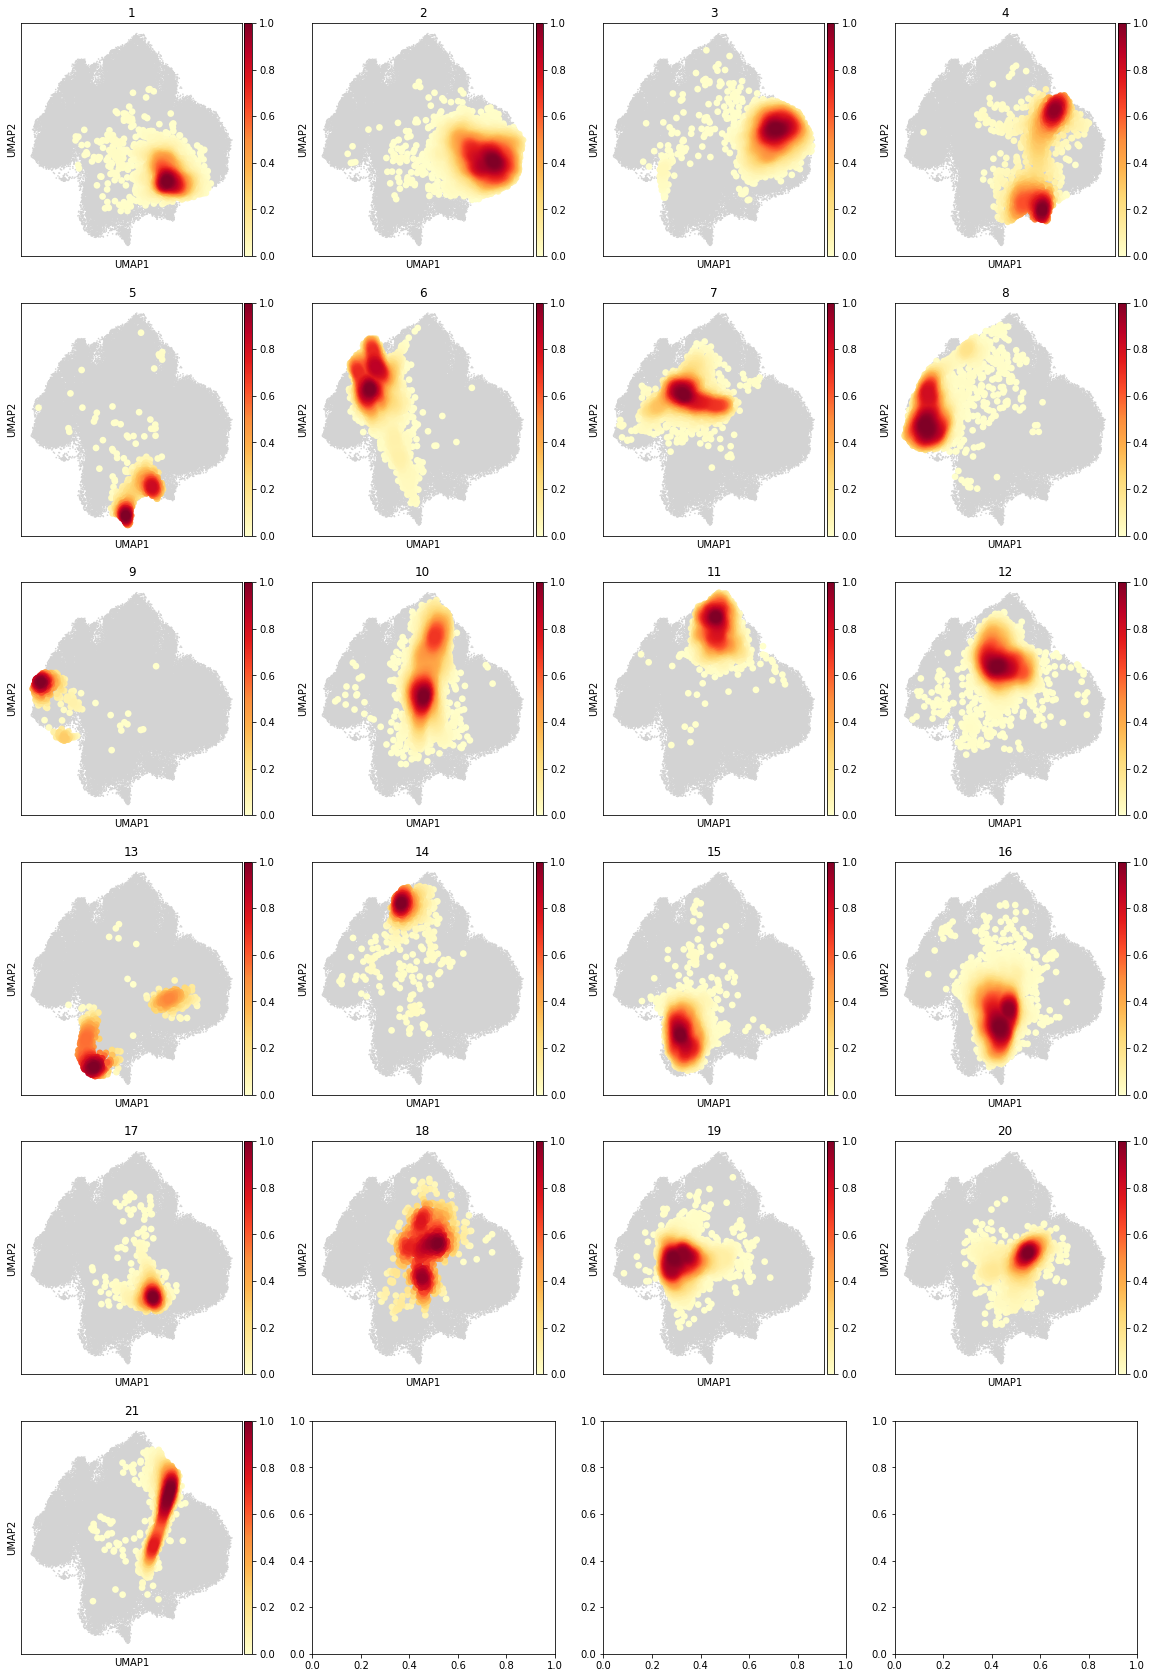

In [71]:
# Densities of clusters on UMAP
# Prepare figure grid
ncl=adata_rn_b.obs.hc_gene_programs.nunique()
fig_cols=4
fig_rows=math.ceil(ncl/fig_cols)
rcParams['figure.figsize']= (5*fig_cols,5*fig_rows)
fig,axs=plt.subplots(fig_rows,fig_cols)
# Calculagte density
idx_row=0
idx_col=-1
for idx,cl in enumerate(sorted(adata_rn_b.obs.hc_gene_programs.unique())):
    if idx%fig_cols==0 and idx!=0:
        idx_row+=1
        idx_col=0
    else:
        idx_col+=1
    subset=adata_rn_b.obs.hc_gene_programs==cl
    adata_sub_ss=adata_rn_b[subset,:].copy()
    sc.tl.embedding_density(adata_sub_ss)
    ax=axs[idx_row,idx_col]
    sc.pl.umap(adata_rn_b,ax=ax,s=10,show=False)
    sc.pl.embedding_density(adata_sub_ss,ax=ax,title=str(cl),show=False) 
del adata_sub_ss

C: Most clusters are localised in single embedidng positions, while a few are stretched. But based on GP expression across pseudobulks it seems that cells are similar on GP level. The stretched clusters are one small cluster with potentially stressed cells 13 and cluster 4 containing some low quality cells. So the clusters that are of main interest for downstream analysis seem to correspond well between GP scores based clustering and integrated embedding.

### Cluster-study/sample proportions

##### Normalised by study/sample

Proportion of cells of each group in each study

<AxesSubplot:>

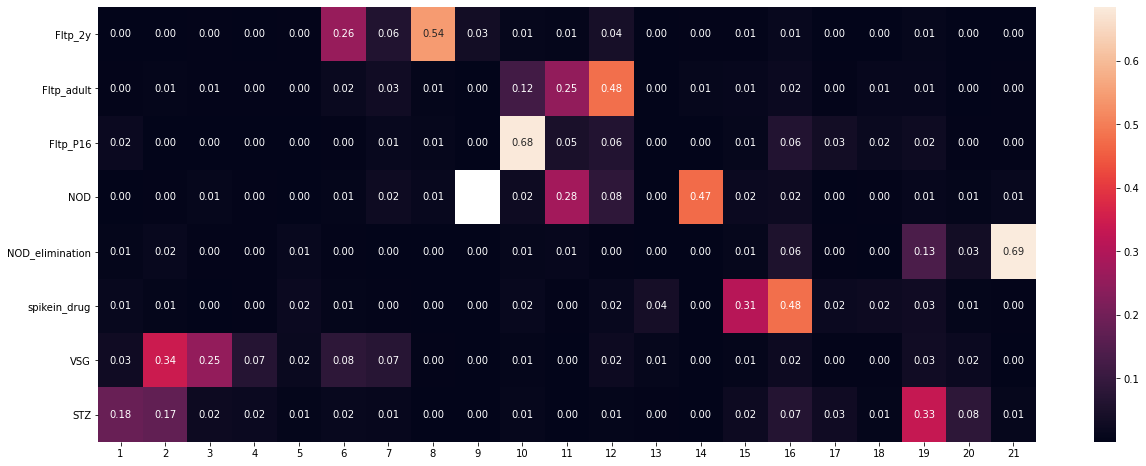

In [158]:
group_study_ratios=pd.DataFrame()
for (study,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby('study',observed=True)['hc_programs'].\
        value_counts(normalize=True,sort=False).iteritems():
    group_study_ratios.at[study,hc]=ratio
fig,ax=plt.subplots(figsize=(group_study_ratios.shape[1],group_study_ratios.shape[0]))
sb.heatmap(group_study_ratios,ax=ax,annot=True,fmt='.2f')

Proportions in samples across studies

In [56]:
# Ratios
group_sample_ratios=pd.DataFrame()
for (sample,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby('study_sample_design',observed=True)['hc_programs'].\
        value_counts(normalize=True,sort=False).iteritems():
    group_sample_ratios.at[sample,hc]=ratio 
group_sample_ratios.fillna(0,inplace=True)    

# Add design and study info for sorting and anno
group_sample_ratios['design']=[
    adata_rn_b.obs.query('study_sample_design==@sample').design.values[0]  
    for sample in group_sample_ratios.index]
group_sample_ratios['design']=pd.Categorical(group_sample_ratios['design'],
              categories=['mRFP','mTmG','mGFP',
              'head_Fltp-','tail_Fltp-', 'head_Fltp+', 'tail_Fltp+',
              'IRE1alphafl/fl','IRE1alphabeta-/-', 
              '8w','14w', '16w',
              'DMSO_r1','DMSO_r2', 'DMSO_r3','GABA_r1','GABA_r2', 'GABA_r3',
                   'A1_r1','A1_r2','A1_r3','A10_r1','A10_r2', 'A10_r3',  'FOXO_r1', 'FOXO_r2', 'FOXO_r3', 
              'E12.5','E13.5','E14.5', 'E15.5', 
              'chow_WT','sham_Lepr-/-','PF_Lepr-/-','VSG_Lepr-/-',   
              'control','STZ', 'STZ_GLP-1','STZ_estrogen', 'STZ_GLP-1_estrogen',
                  'STZ_insulin','STZ_GLP-1_estrogen+insulin' 
            ],
            ordered=True)
group_sample_ratios['study']=[
    adata_rn_b.obs.query('study_sample_design==@sample').study.values[0]  
    for sample in group_sample_ratios.index]
# Sort rows 
group_sample_ratios=group_sample_ratios.sort_values(['study','design'])
# Save study info
studies=group_sample_ratios.study.values
study_cmap=dict(zip(adata_rn_b.obs.study.cat.categories,adata_rn_b.uns['study_colors']))
study_colors=[study_cmap[s] for s in studies]
# Drop unused cols
group_sample_ratios.drop(['study','design'],axis=1,inplace=True)
# Sort/select columns
group_sample_ratios=group_sample_ratios[adata_rn_b.obs.hc_programs.cat.categories]

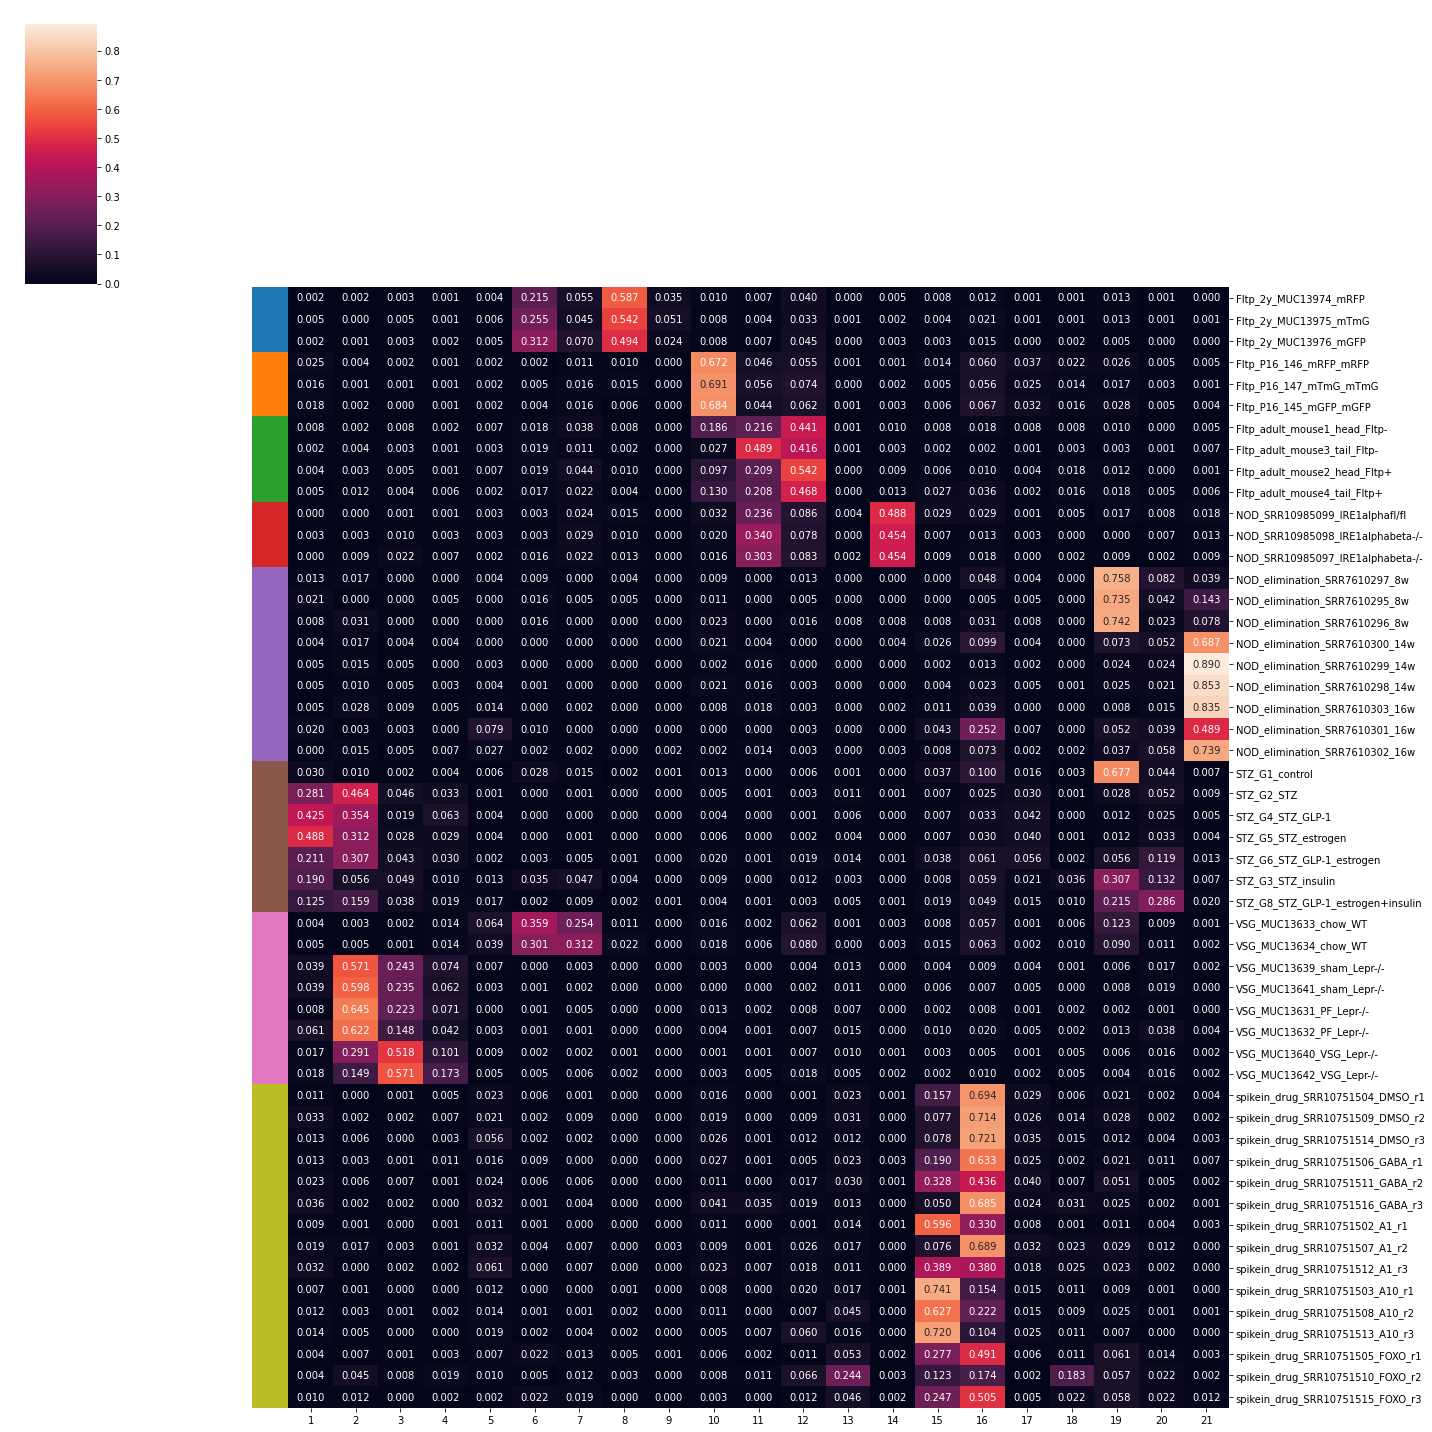

In [57]:
sb.clustermap(group_sample_ratios,row_colors=study_colors,annot=True,fmt='.3f',
             col_cluster=False,row_cluster=False,
             xticklabels=True,yticklabels=True,figsize=(20,20))

##### Normalised by cluster

Proportion of cells of each study in each group

<AxesSubplot:>

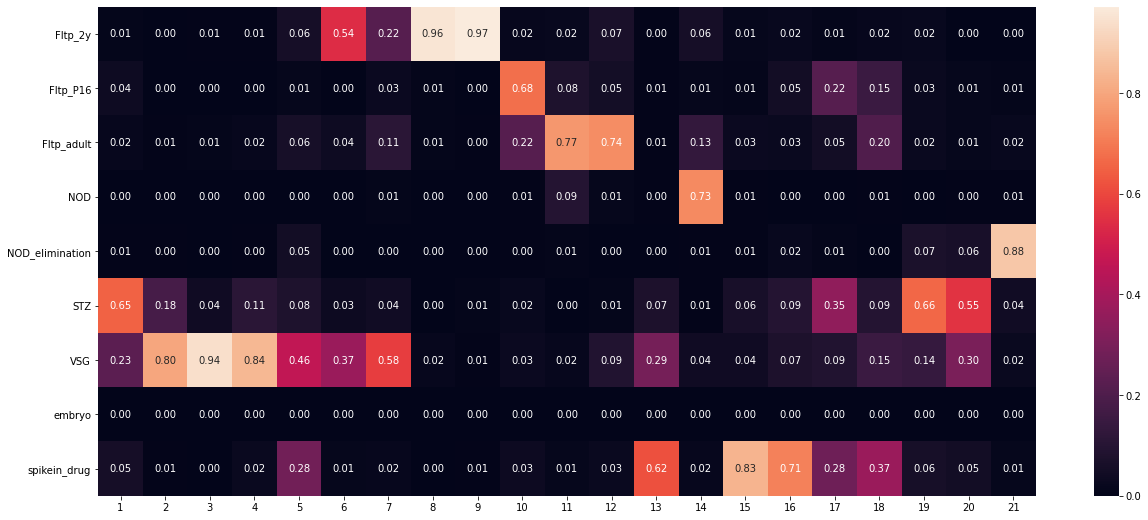

In [13]:
group_study_ratios=pd.DataFrame()
for (study,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby('hc_programs',observed=True)['study'].\
        value_counts(normalize=True,sort=False).iteritems():
    group_study_ratios.at[study,hc]=ratio
group_study_ratios= group_study_ratios.T
fig,ax=plt.subplots(figsize=(group_study_ratios.shape[1],group_study_ratios.shape[0]))
sb.heatmap(group_study_ratios,ax=ax,annot=True,fmt='.2f')

Sample proportions across clusters

In [11]:
# Ratios
group_sample_ratios=pd.DataFrame()
for (sample,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby('hc_programs',observed=True)['study_sample_design'].\
        value_counts(normalize=True,sort=False).iteritems():
    group_sample_ratios.at[sample,hc]=ratio 
group_sample_ratios.fillna(0,inplace=True) 
group_sample_ratios=group_sample_ratios.T

# Add design and study info for sorting and anno
group_sample_ratios['design']=[
    adata_rn_b.obs.query('study_sample_design==@sample').design.values[0]  
    for sample in group_sample_ratios.index]
group_sample_ratios['design']=pd.Categorical(group_sample_ratios['design'],
              categories=['mRFP','mTmG','mGFP',
              'head_Fltp-','tail_Fltp-', 'head_Fltp+', 'tail_Fltp+',
              'IRE1alphafl/fl','IRE1alphabeta-/-', 
              '8w','14w', '16w',
              'DMSO_r1','DMSO_r2', 'DMSO_r3','GABA_r1','GABA_r2', 'GABA_r3',
                   'A1_r1','A1_r2','A1_r3','A10_r1','A10_r2', 'A10_r3',  'FOXO_r1', 'FOXO_r2', 'FOXO_r3', 
              'E12.5','E13.5','E14.5', 'E15.5', 
              'chow_WT','sham_Lepr-/-','PF_Lepr-/-','VSG_Lepr-/-',   
              'control','STZ', 'STZ_GLP-1','STZ_estrogen', 'STZ_GLP-1_estrogen',
                  'STZ_insulin','STZ_GLP-1_estrogen+insulin' 
            ],
            ordered=True)
group_sample_ratios['study']=[
    adata_rn_b.obs.query('study_sample_design==@sample').study.values[0]  
    for sample in group_sample_ratios.index]
# Sort rows 
group_sample_ratios=group_sample_ratios.sort_values(['study','design'])
# Save study info
studies=group_sample_ratios.study.values
study_cmap=dict(zip(adata_rn_b.obs.study.cat.categories,adata_rn_b.uns['study_colors']))
study_colors=[study_cmap[s] for s in studies]
# Drop unused cols
group_sample_ratios.drop(['study','design'],axis=1,inplace=True)
# Sort/select columns
group_sample_ratios=group_sample_ratios[adata_rn_b.obs.hc_programs.cat.categories]

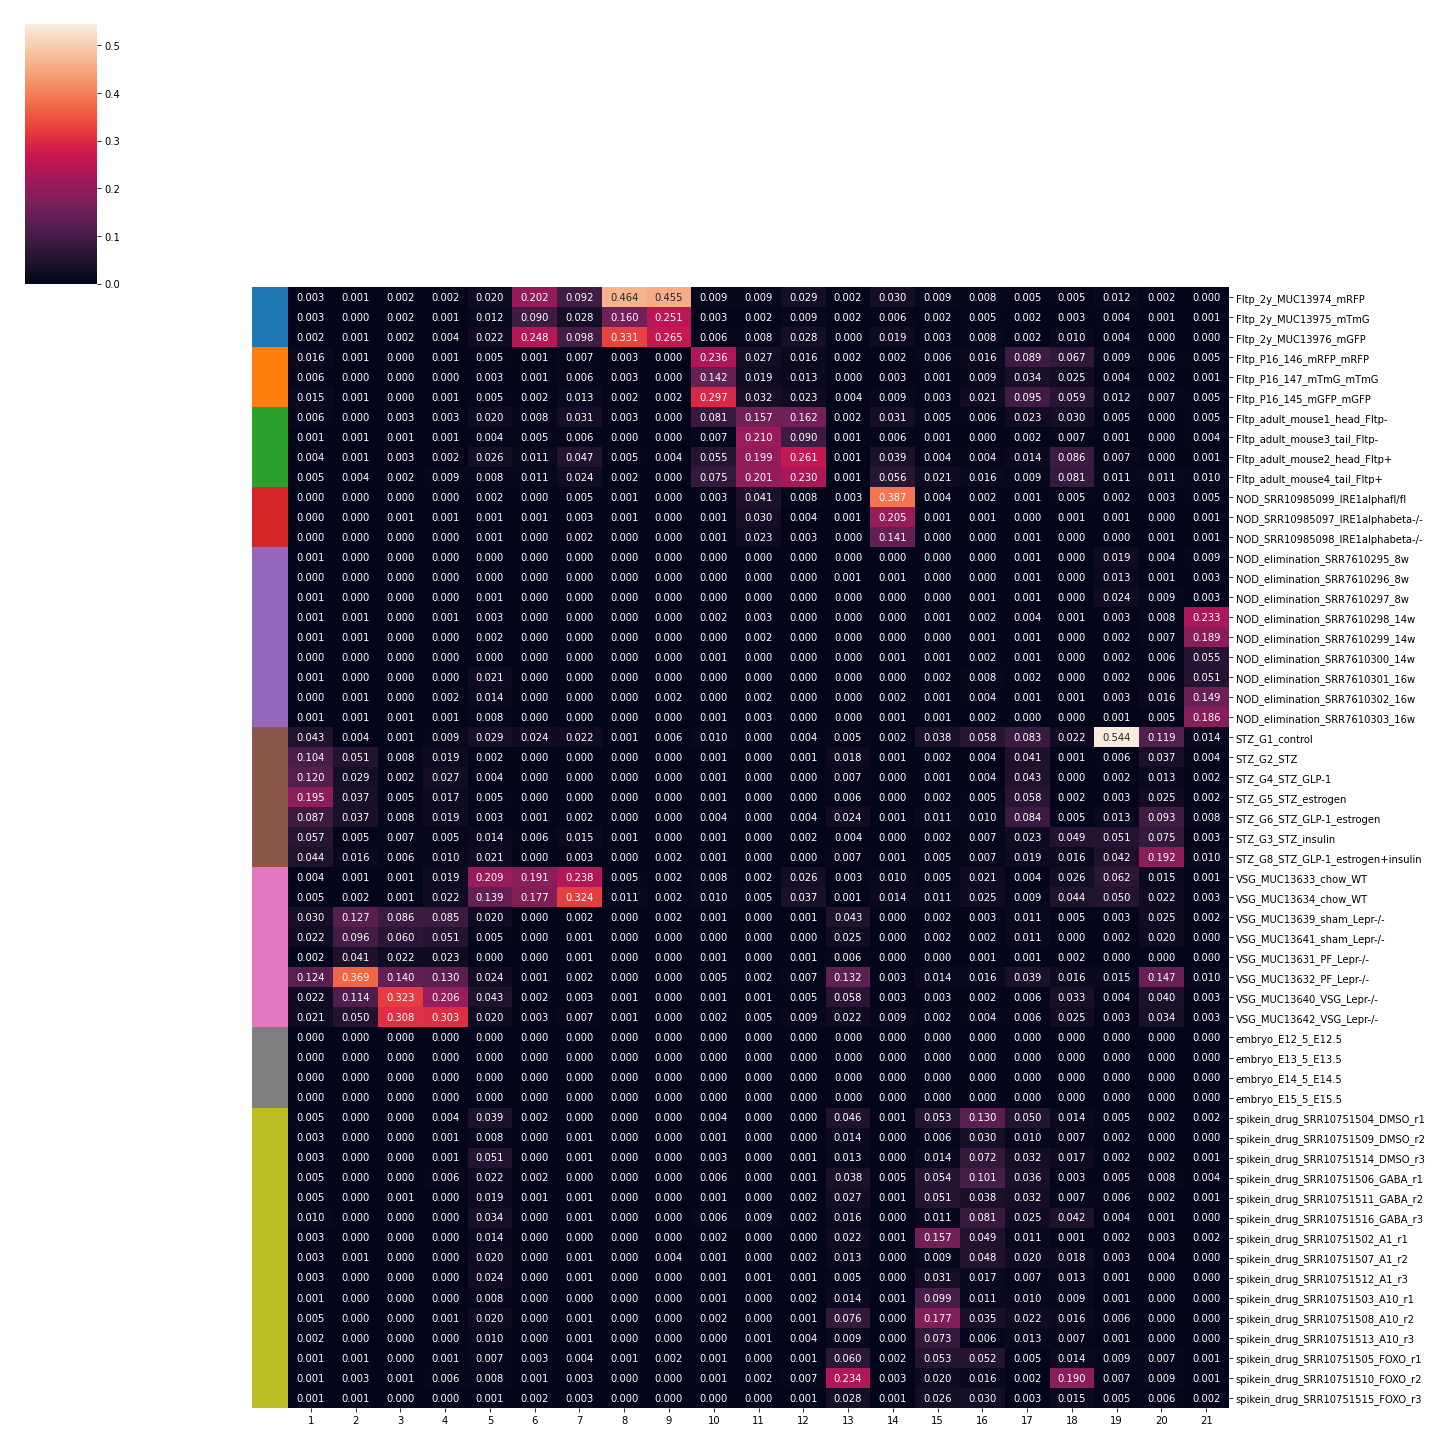

In [12]:
sb.clustermap(group_sample_ratios,row_colors=study_colors,annot=True,fmt='.3f',
             col_cluster=False,row_cluster=False,
             xticklabels=True,yticklabels=True,figsize=(20,20))

### Markers/QC/metadata across clusters

Metadata and QC

<AxesSubplot:ylabel='hc_gene_programs'>

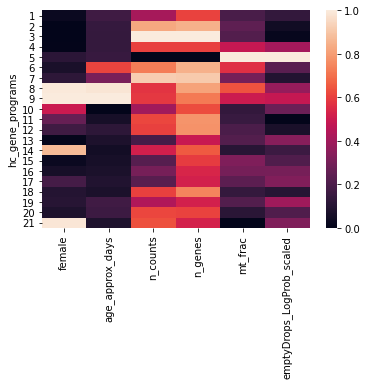

In [11]:
# metadata across clusters, scaled across clusters
adata_rn_b.obs['female']=(adata_rn_b.obs.sex=='female').astype(int)
covars=adata_rn_b.obs.groupby('hc_gene_programs')[['female','age_approx_days',
                                            'n_counts', 'n_genes', 'mt_frac', 
                                            'emptyDrops_LogProb_scaled']].mean()
covars=pd.DataFrame(minmax_scale(covars),
                    index=covars.index,columns=covars.columns)
sb.heatmap(covars,
          xticklabels=True,yticklabels=True)

Expression of known markers

In [12]:
known_markers={
    'beta':['Ins1','Ins2','Nkx6-1','Pdx1'],
    'mature':['Mafa','Ucn3','Slc2a2'],
    'immature':['Rbp4','Cd81','Mafb'],
    'aged':['Cdkn2a','Trp53bp1'], 
    'T1D':['B2m'],
    'T2D':['Gast','Gc','Aldh1a3','Cck','Aldob','Chgb'],
    'mt':['mt-Nd1','mt-Co3','mt-Atp6'],
    }

In [13]:
# Make adata where sex and quality scores can be added to dotplot
markers_all=[m for ms in known_markers.values() for m in ms]
adata_temp=sc.AnnData(pd.concat([
    adata_rn_b[:,adata_rn_b.var.query('gene_symbol in @markers_all').index].to_df(),
    adata_rn_b.obs[['n_counts', 'n_genes', 'mt_frac']],
    # Map sex to numbers. use all >0 as else will affect circle size. 
    # As normalised from 0 to 1 anyway it can be 2-1 here
    pd.DataFrame(adata_rn_b.obs['sex'].map({'female':2,'male':1}).rename('female'))],
    axis=1))
adata_temp.var_names=[adata_rn_b.var.at[col,'gene_symbol'] if col in adata_rn_b.var_names
                      else col for col in adata_temp.var_names ]
adata_temp.obs['hc_gene_programs']=adata_rn_b.obs['hc_gene_programs']

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


{'mainplot_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

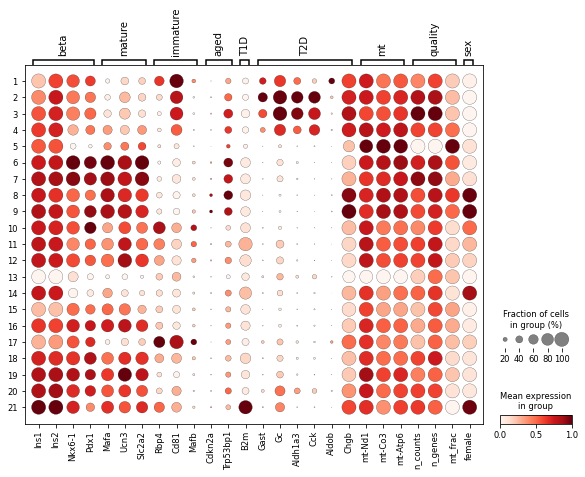

In [16]:
# Dotplot of all cells, including low quality
fig,ax=plt.subplots(
    figsize=(adata_temp.shape[1]*0.3+2, 
             adata_temp.obs['hc_gene_programs'].nunique()*0.3+1.2)
)
# Add extra cols as markers
markers=known_markers.copy()
markers['quality']=['n_counts', 'n_genes', 'mt_frac']
markers['sex']=['female']
sc.pl.dotplot(adata_temp,var_names=markers,
              groupby='hc_gene_programs',standard_scale='var',ax=ax,show=False)

## Save clusters

In [174]:
# Save clusters by adding them to adata on disk
h.update_adata(adata_rn_b,
               path=path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',
               add=[('obs',True,'hc_programs','hc_gene_programs')],
               rm=None,unique_id2=None,io_copy=False)

#### Parse names

In [12]:
cluster_map={
    1:'mSTZ',
    2:'db/db+mSTZ',
    3:'db/db-VSG',
    4:'db/db-VSG+lowQ',
    5:'lowQ',
    6:'adult+agedM',
    7:'adult1',
    8:'agedF1',
    9:'agedF2',
    10:'imm.1',
    11:'imm.2',
    12:'adult-imm.1',
    13:'chem1',
    14:'NOD-imm.',
    15:'chem2',
    16:'chem3',
    17:'imm.3',
    18:'adult-imm.2',
    19:'adult2',
    20:'D-inter.',
    21:'NOD-D'
}
adata_rn_b.obs['hc_gene_programs_parsed']=adata_rn_b.obs['hc_gene_programs'].map(cluster_map)
cmap=dict(zip(adata_rn_b.obs['hc_gene_programs_parsed'].cat.categories,
               color_list[:adata_rn_b.obs['hc_gene_programs_parsed'].nunique()]))
# Set order of clusters and colors
cl_order=[
 'imm.1',
 'imm.2',
 'imm.3',
 'NOD-imm.',
 'adult-imm.1',
 'adult-imm.2',
 'adult1',
 'adult2',
 'adult+agedM',
 'agedF1',
 'agedF2',
 'D-inter.',
 'NOD-D',
 'db/db+mSTZ',
 'mSTZ',
 'db/db-VSG',
 'db/db-VSG+lowQ',
 'chem1',
 'chem2',
 'chem3',
 'lowQ']
adata_rn_b.obs['hc_gene_programs_parsed']=pd.Categorical(
    values=adata_rn_b.obs['hc_gene_programs_parsed'],
    categories=cl_order,ordered=True)
adata_rn_b.uns['hc_gene_programs_parsed_colors']=[
    cmap[cl] for cl in adata_rn_b.obs['hc_gene_programs_parsed'].cat.categories]
adata_rn_b.uns['hc_gene_programs_parsed_order']=cl_order

In [13]:
# Check that N clusters is retained
print(adata_rn_b.obs['hc_gene_programs_parsed'].nunique())

21


In [15]:
# Save parsed anno and colors
if True:
    h.update_adata(
            adata_new=adata_rn_b, path=path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',
            io_copy=False,
            add=[('obs',True,'hc_gene_programs_parsed','hc_gene_programs_parsed'),
                 ('uns',True,'hc_gene_programs_parsed_colors','hc_gene_programs_parsed_colors'),
                 ('uns',True,'hc_gene_programs_parsed_order','hc_gene_programs_parsed_order')],
        rm=None)

## Plot figures for paper

UMAP of parsed clusters. Note: This and the next UMAPs requires a beta cell UMAP embedding that is computed in a later noltebook (optimising beta cell UMAP for clearer visualisation).

Trying to set attribute `.uns` of view, copying.


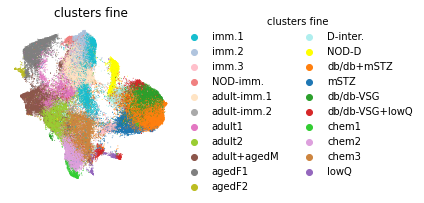

In [8]:
fig,ax=plt.subplots(figsize=(3,3))
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_rn_b.shape[0])))
sc.pl.embedding(adata_rn_b[random_indices,:],'X_umap_opt',color='hc_gene_programs_parsed',s=3,
          palette=list(adata_rn_b.uns['hc_gene_programs_parsed_colors']),
           ax=ax,frameon=False,show=False,title='clusters fine')
ax.legend_.set_title('clusters fine')
plt.savefig(path_fig+'umap_beta_CLfine_eopt.png',dpi=300,bbox_inches='tight')

Clusters on UMAP, excluding low quality clusters

Trying to set attribute `.uns` of view, copying.


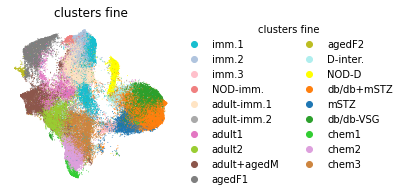

In [10]:
fig,ax=plt.subplots(figsize=(3,3))
np.random.seed(0)
subset=~adata_rn_b.obs['hc_gene_programs_parsed'].str.contains('lowQ')
random_indices=np.random.permutation(list(range(adata_rn_b[subset,:].shape[0])))
sc.pl.embedding(adata_rn_b[subset,:][random_indices,:],'X_umap_opt',
                color='hc_gene_programs_parsed',s=3,
          palette=dict(zip(adata_rn_b.uns['hc_gene_programs_parsed_order'],
                           adata_rn_b.uns['hc_gene_programs_parsed_colors'])),
           ax=ax,frameon=False,show=False,title='clusters fine')
ax.legend_.set_title('clusters fine')
plt.savefig(path_fig+'umap_beta_CLfine_nolowQ_eopt.png',dpi=300,bbox_inches='tight')

GP activity in parsed clusters

<ipython-input-17-95ebef29f5ad>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudobulk_gp_scaled['cl']=adata_rn_b.obs.loc[pseudobulk_gp_scaled.index,


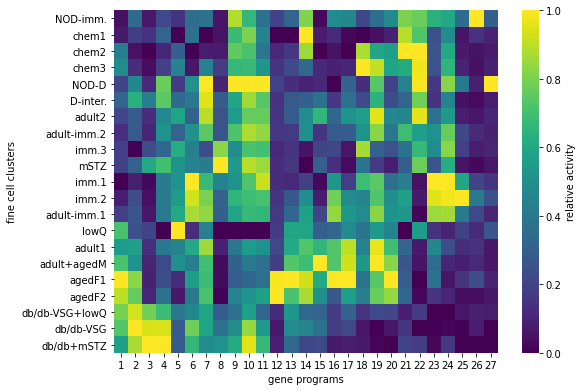

In [17]:
# Make pseudobulk
pseudobulk_gp_scaled=adata_rn_b.obs[[col for col in adata_rn_b.obs.columns
        if 'gene_score_cluster_hc' in col and '_scaled' not in col]]
# Scale cells - UNUSED scale below
#pseudobulk_gp_scaled=pd.DataFrame(scale(pseudobulk_gp_scaled),  
#                                  index=pseudobulk_gp_scaled.index,  
#                                  columns=pseudobulk_gp_scaled.columns)

# Mean within beta clusters of gene programs
pseudobulk_gp_scaled['cl']=adata_rn_b.obs.loc[pseudobulk_gp_scaled.index,
                                              'hc_gene_programs_parsed']
pseudobulk_gp_scaled=pseudobulk_gp_scaled.groupby('cl', observed=True).mean()
pseudobulk_gp_scaled.index.name='fine cell clusters'

# Scale
pseudobulk_gp_scaled=pd.DataFrame(minmax_scale(pseudobulk_gp_scaled),
                                 index=pseudobulk_gp_scaled.index,
                                 columns=pseudobulk_gp_scaled.columns)

# Order cell clusters
pseudobulk_gp_scaled=pseudobulk_gp_scaled.loc[
    pseudobulk_gp_scaled.index[h.opt_order(pseudobulk_gp_scaled,metric='correlation',
                                           method='ward')],:]

# rename columns to be shorter
pseudobulk_gp_scaled.columns=[col.replace('gene_score_cluster_hc','')
                           for col in pseudobulk_gp_scaled.columns]
pseudobulk_gp_scaled.columns.name='gene programs'

# Plot
fig,ax=plt.subplots(figsize=(pseudobulk_gp_scaled.shape[1]*0.3+0.5,
                             pseudobulk_gp_scaled.shape[0]*0.3))
vmaxabs=abs(pseudobulk_gp_scaled).max().max()
sb.heatmap(pseudobulk_gp_scaled,
           #vmin=-vmaxabs,vmax=vmaxabs,
             cbar_kws={'label': 'relative activity'},
          cmap='viridis')
plt.savefig(path_fig+'heatmap_beta_gpacitivity_CLfine.png',dpi=300,bbox_inches='tight')

Known markers

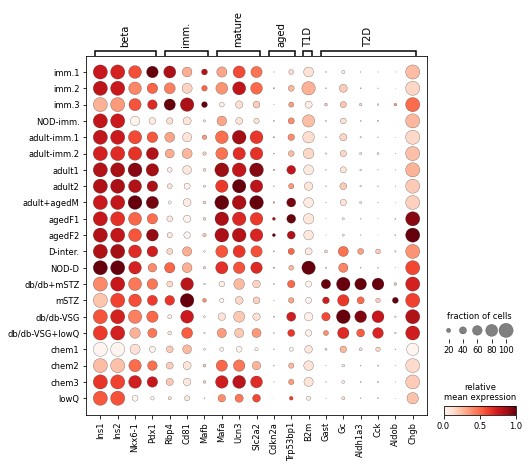

In [18]:
# Markers
known_markers={
    'beta':['Ins1','Ins2','Nkx6-1','Pdx1'],
    'imm.':['Rbp4','Cd81','Mafb'],
    'mature':['Mafa','Ucn3','Slc2a2'],
    'aged':['Cdkn2a','Trp53bp1'], 
    'T1D':['B2m'],
    'T2D':['Gast','Gc','Aldh1a3','Cck','Aldob','Chgb'],
    }
fig,ax=plt.subplots(
    figsize=(len([g for gs in known_markers.values() for g in gs])*0.3+2, 
             adata_rn_b.obs['hc_gene_programs_parsed'].nunique()*0.3+1.2)
)
sc.pl.dotplot(adata_rn_b,var_names=known_markers,gene_symbols='gene_symbol',
              size_title='fraction of cells',
              colorbar_title='relative\nmean expression',
              groupby='hc_gene_programs_parsed',standard_scale='var',ax=ax,show=False)
plt.savefig(path_fig+'dotplot_beta_CLfine_knownmarkers.png',dpi=300,bbox_inches='tight')

QC and metadata

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


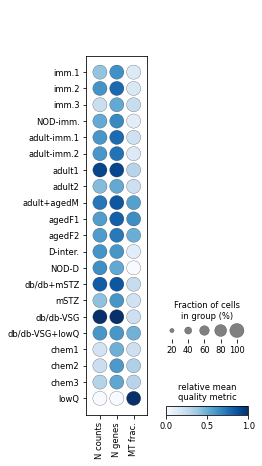

In [19]:
# Quality scores
qcs=['n_counts', 'n_genes', 'mt_frac']
qcs_map={'n_counts':'N counts', 'n_genes':'N genes', 'mt_frac':'MT frac.'}
adata_temp=sc.AnnData(adata_rn_b.obs[qcs])
adata_temp.obs['hc_gene_programs_parsed']=adata_rn_b.obs['hc_gene_programs_parsed']
adata_temp.var_names=[qcs_map[v] for v in adata_temp.var_names]
fig,ax=plt.subplots(
    figsize=(adata_temp.shape[1]*0.3+2, 
             adata_rn_b.obs['hc_gene_programs_parsed'].nunique()*0.3+1.2)
)
sc.pl.dotplot(adata_temp,var_names=list(qcs_map.values()),cmap='Blues',
               colorbar_title='relative mean\nquality metric',
              groupby='hc_gene_programs_parsed',standard_scale='var',ax=ax,show=False)
plt.savefig(path_fig+'dotplot_beta_CLfine_QC.png',dpi=300,bbox_inches='tight')
del adata_temp

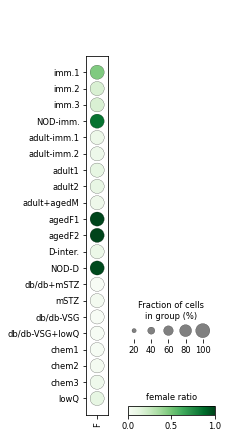

In [20]:
# Sex
# Map sex to numbers. use all >0 as else will affect circle size. 
# As normalised from 0 to 1 anyway it can be 2-1 here
adata_temp=sc.AnnData(
    pd.DataFrame(adata_rn_b.obs['sex'].map({'female':2,'male':1}).rename('F')))
adata_temp.obs['hc_gene_programs_parsed']=adata_rn_b.obs['hc_gene_programs_parsed']
fig,ax=plt.subplots(
    figsize=(adata_temp.shape[1]*0.3+2, 
             adata_rn_b.obs['hc_gene_programs_parsed'].nunique()*0.3+1.2)
)
sc.pl.dotplot(adata_temp,var_names='F',cmap='Greens',
               colorbar_title='female ratio',
              groupby='hc_gene_programs_parsed',standard_scale='var',ax=ax,show=False)
plt.savefig(path_fig+'dotplot_beta_CLfine_sex.png',dpi=300,bbox_inches='tight')
del adata_temp

Proportions in samples across studies

In [21]:
# Ratios
group_sample_ratios=pd.DataFrame()
adata_rn_b.obs['studyparsed_design_sample']=[
    '_'.join(i) for i in 
     zip(adata_rn_b.obs.study_parsed,adata_rn_b.obs.design,adata_rn_b.obs.file)]
for (sample,hc),ratio in adata_rn_b.obs.query('study!="embryo"').\
        groupby('studyparsed_design_sample',observed=True)['hc_gene_programs_parsed'].\
        value_counts(normalize=True,sort=False).iteritems():
    group_sample_ratios.at[sample,hc]=ratio 
group_sample_ratios.fillna(0,inplace=True)    

# Add design and study info for sorting and anno
group_sample_ratios['design']=[
    adata_rn_b.obs.query('studyparsed_design_sample==@sample').design.values[0]  
    for sample in group_sample_ratios.index]
group_sample_ratios['design']=pd.Categorical(group_sample_ratios['design'],
              categories=[ 
              'E12.5','E13.5','E14.5', 'E15.5', 
                  'mRFP','mTmG','mGFP',
              'head_Fltp-','tail_Fltp-', 'head_Fltp+', 'tail_Fltp+',
              'DMSO_r1','DMSO_r2', 'DMSO_r3','GABA_r1','GABA_r2', 'GABA_r3',
                   'A1_r1','A1_r2','A1_r3','A10_r1','A10_r2', 'A10_r3',  'FOXO_r1', 'FOXO_r2', 'FOXO_r3',
              'IRE1alphafl/fl','IRE1alphabeta-/-', 
              '8w','14w', '16w',
              'control','STZ', 'STZ_GLP-1','STZ_estrogen', 'STZ_GLP-1_estrogen',
                  'STZ_insulin','STZ_GLP-1_estrogen+insulin' ,
                  'chow_WT','sham_Lepr-/-','PF_Lepr-/-','VSG_Lepr-/-',   
            ],
            ordered=True)
group_sample_ratios['study']=[
    adata_rn_b.obs.query('studyparsed_design_sample==@sample').study_parsed.values[0]  
    for sample in group_sample_ratios.index]
studies_order=adata_rn_b.uns['study_parsed_order']
group_sample_ratios['study']=pd.Categorical(
    group_sample_ratios['study'],ordered=True,
    categories=studies_order)
# Sort rows 
group_sample_ratios=group_sample_ratios.sort_values(['study','design'])
# Save study info
studies=group_sample_ratios.study.values
# Drop unused cols
group_sample_ratios.drop(['study','design'],axis=1,inplace=True)
# Sort/select columns
group_sample_ratios=group_sample_ratios[adata_rn_b.obs['hc_gene_programs_parsed'].cat.categories]

# Order columns
#group_sample_ratios=group_sample_ratios.iloc[:,
#    h.opt_order(group_sample_ratios.T,metric='correlation',method='ward')]

# Add rowcolors 

# Study
#sc.pl._utils._set_default_colors_for_categorical_obs(adata_rn_b, 'study_parsed')
study_cmap=dict(zip(adata_rn_b.obs.study_parsed.cat.categories,
                    adata_rn_b.uns['study_parsed_colors']))
study_cmap={s:study_cmap[s] for s in studies_order}
del study_cmap['embryonic']
study_colors=[study_cmap[s] for s in studies]

# Age map
study_parsed_map=dict(zip(adata_rn_b.obs.study_parsed,adata_rn_b.obs.study))
study_age_categ={
    'Fltp_2y':'2y', 
    'Fltp_adult':'3-7m', 
    'Fltp_P16':'0-1m', 
    'NOD':'1-1.5m', 
   # 'NOD_elimination':None, 
    'spikein_drug':'2-3m', 
    'VSG':'3-7m', 
    'STZ':'3-7m'}
ages_order=['0-1m','1-1.5m','1.5-2m','2-3m','3-7m','2y']
normalize = mcolors.Normalize(vmin=0,  vmax=len(ages_order)-1)
age_cmap={age:cm.viridis(normalize(idx)) for idx,age in enumerate(ages_order)}
ages=[]
for sample,study in zip(group_sample_ratios.index,studies):
    study=study_parsed_map[study]
    if study=='NOD_elimination':
        if '8w' in sample:
            age='1.5-2m'
        else:
            age='3-7m'
    else:
        age=study_age_categ[study]
    ages.append(age)
age_colors=[age_cmap[a] for a in ages]

# Perturbation map
perturbation_map={}
for sample in group_sample_ratios.index:
    if 'mSTZ' in sample and 'control' not in sample:
        p='mSTZ'
    elif 'db/db' in sample and 'WT' not in sample:
        p='db/db'
    elif 'chem' in sample and 'DMSO' not in sample:
        p='other chemical'
    elif 'NOD' in sample:
        p='NOD'
    else:
        p='none'
    perturbation_map[sample]=p
perturbation_cmap={'NOD':'#58017B','mSTZ':'#E06397','db/db':'#9A0A0A',
                   'other chemical':'#A2B308','none':'#C3C3C3'}
perturbation_colors=[perturbation_cmap[ perturbation_map[s]] for s in group_sample_ratios.index]

# Combine anno
blank=['#FFFFFF']*group_sample_ratios.shape[0]
row_anno=pd.DataFrame({'perturbation':perturbation_colors,
                       'age group':age_colors,
                      'study':study_colors,'':blank},
                      index=group_sample_ratios.index)

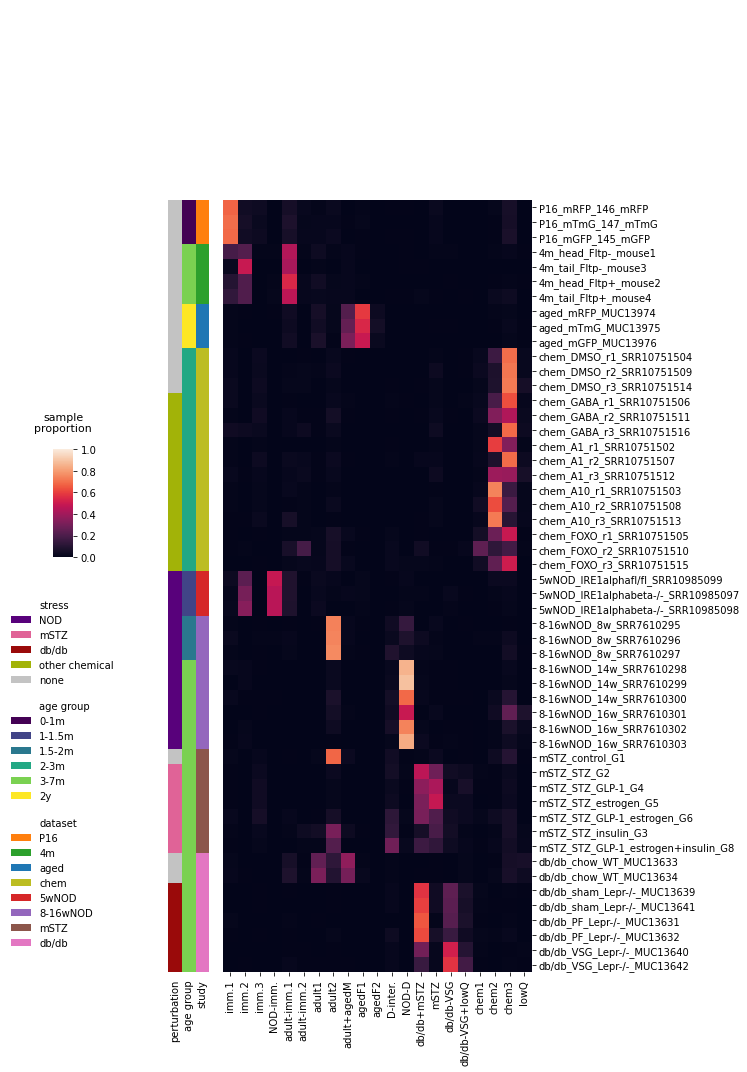

In [23]:
# Cmap
g=sb.clustermap(group_sample_ratios,row_colors=row_anno,
                #annot=True,fmt='.2f',
             col_cluster=False,row_cluster=False,
             xticklabels=True,yticklabels=True,figsize=(9.5,15),vmin=0,vmax=1,
               colors_ratio=0.03,cbar_pos=(-0.02,0.48,0.03,0.1))
g.cax.set_title("sample\nproportion\n",fontsize=11)
# Remove row colors tick
g.ax_row_colors.xaxis.set_ticks_position('none') 

# Add legend for row colors
legend_elements = [ Patch(alpha=0,label='stress')]+[
     Patch(facecolor=perturbation_cmap[s],label=s) 
    for s in ['NOD','mSTZ','db/db','other chemical','none']
]+[ Patch(alpha=0,label='\nage group')]+[
     Patch(facecolor=c,label=s) for s,c in age_cmap.items()
]+[ Patch(alpha=0,label='\ndataset')]+[
     Patch(facecolor=c,label=s) for s,c in study_cmap.items()
]
ax=g.fig.add_subplot(223)
ax.axis('off')
ax.legend(handles=legend_elements, bbox_to_anchor=(0.2,0.79),frameon=False)

# Save
plt.savefig(path_fig+'heatmap_beta_CLfine_samples.png',dpi=300,bbox_inches='tight')

### PAGA

Compute PAGA

In [112]:
sc.tl.paga(adata_rn_b,groups='hc_gene_programs_parsed')

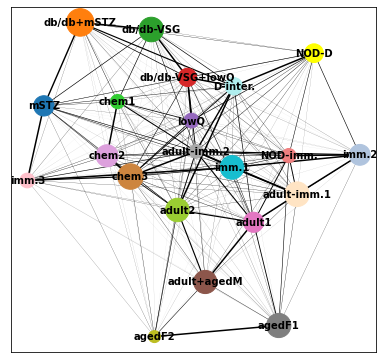

In [9]:
rcParams['figure.figsize']=(6,6)
sc.pl.paga(adata_rn_b,color='hc_gene_programs_parsed',node_size_scale=3,
           layout='fa',random_state=0,edge_width_scale=0.2)

Select PAGA prunning threshold

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


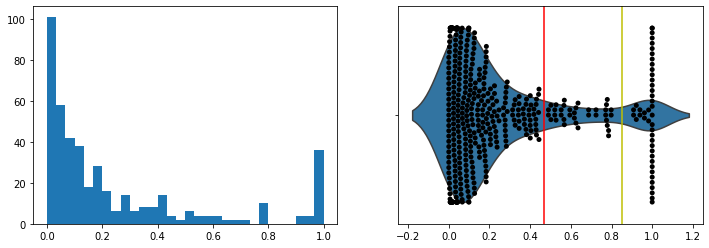

In [10]:
# Distn of PAGA connectivities
fig,axs=plt.subplots(1,2,figsize=(12,4))
paga_conn=adata_rn_b.uns['paga']['connectivities'].toarray().ravel()
a=axs[0].hist(paga_conn,bins=30)
sb.violinplot(paga_conn,ax=axs[1], inner=None)
sb.swarmplot(paga_conn,ax=axs[1],color='k')
thr=0.47
axs[1].axvline(thr,c='r')
axs[1].axvline(0.85,c='y')

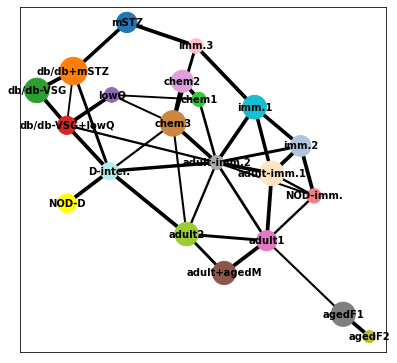

In [11]:
sc.pl.paga(adata_rn_b, color='hc_gene_programs_parsed',threshold=thr,
           node_size_scale=3,layout='fa',edge_width_scale=0.5,
           random_state=0)

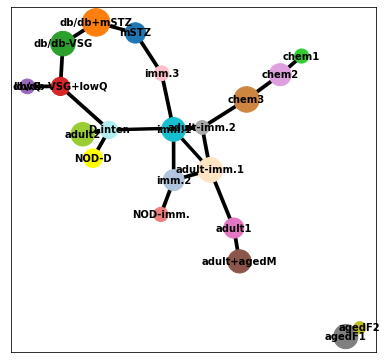

In [13]:
# Lower thr
sc.pl.paga(adata_rn_b, color='hc_gene_programs_parsed',threshold=0.85,
           node_size_scale=3,layout='fa',edge_width_scale=0.5,
           random_state=0)

Selected PAGA plot for paper

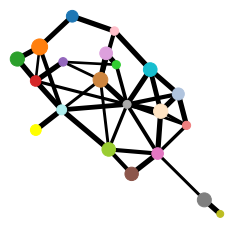

In [14]:
# PAGA plot for the paper
fig,ax=plt.subplots(figsize=(4,4))
sc.pl.paga(adata_rn_b, color='hc_gene_programs_parsed',threshold=thr,
           node_size_scale=1,layout='fa',edge_width_scale=0.7,
           labels=['']*adata_rn_b.obs['hc_gene_programs_parsed'].nunique(),
           random_state=0, show=False,frameon=False,ax=ax)
plt.savefig(path_fig+'paga_beta_CLfine.png',dpi=300,bbox_inches='tight')

#### Mark edges
Mark specific edges on PAGA and overlay on beta cell UMAP embedding

In [15]:
# Defined solid  edges (use all edges as dashed)
groups=adata_rn_b.obs[adata_rn_b.uns['paga']['groups']].cat.categories
adata_rn_b.uns['paga']['connectivities_solid']=np.zeros((len(groups),len(groups)))
for n1,n2 in [('adult2','D-inter.'),('D-inter.','NOD-D'),('D-inter.','db/db+mSTZ')]:
    idx1=np.argwhere(groups==n1)[0][0]
    idx2=np.argwhere(groups==n2)[0][0]
    val=adata_rn_b.uns['paga']['connectivities'][idx1,idx2]
    adata_rn_b.uns['paga']['connectivities_solid'][idx1,idx2]=val
    adata_rn_b.uns['paga']['connectivities_solid'][idx2,idx1]=val
adata_rn_b.uns['paga']['connectivities_solid']=\
    csr_matrix(adata_rn_b.uns['paga']['connectivities_solid'])

In [16]:
# Define positions based on UMAP positions
pos=pd.DataFrame(adata_rn_b.obsm['X_umap_opt'],index=adata_rn_b.obs_names)
pos['group']=adata_rn_b.obs[adata_rn_b.uns['paga']['groups']]
pos=pos.groupby('group').mean()

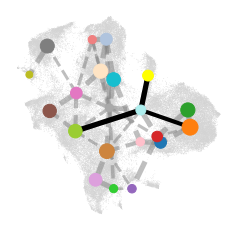

In [18]:
# PAGA plot for the paper
fig,ax=plt.subplots(figsize=(4,4))
sc.pl.embedding(adata_rn_b,'X_umap_opt',show=False,ax=ax)
sc.pl.paga(adata_rn_b, color='hc_gene_programs_parsed',threshold=thr,
           node_size_scale=1,layout='fa',edge_width_scale=0.7,
           labels=['']*adata_rn_b.obs['hc_gene_programs_parsed'].nunique(),
           dashed_edges='connectivities',solid_edges='connectivities_solid',
           #pos=adata_rn_b.uns['paga']['pos'],
           pos=pos.values,
           random_state=0, show=False,frameon=False,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig(path_fig+'paga_beta_CLfine_markedTransition.png',dpi=300,bbox_inches='tight')

Without low Q clusters

In [113]:
# Subset adata
subset=~adata_rn_b.obs['hc_gene_programs_parsed'].str.contains('lowQ')
adata_temp=adata_rn_b[subset,:].copy()
adata_temp.uns['paga']=adata_temp.uns['paga'].copy()
adata_temp.obs['hc_gene_programs_parsed']=pd.Categorical(
    values=adata_temp.obs['hc_gene_programs_parsed'].values,ordered=True,
    categories=[c for c in adata_temp.obs['hc_gene_programs_parsed'].cat.categories 
            if c in adata_temp.obs['hc_gene_programs_parsed'].unique()])
adata_temp.uns['hc_gene_programs_parsed_colors']=[
    c for c,g in zip(adata_rn_b.uns['hc_gene_programs_parsed_colors'],
                     adata_rn_b.obs['hc_gene_programs_parsed'].cat.categories) 
    if 'lowQ' not in g]

In [114]:
# Defined solid  edges (use all edges as dashed)
groups=adata_rn_b.obs[adata_rn_b.uns['paga']['groups']].cat.categories
groups_keep=np.array([g for g in groups if 'lowQ' not in g])
adata_rn_b.uns['paga']['connectivities_solid']=np.zeros((len(groups_keep),len(groups_keep)))
for n1,n2 in [('adult2','D-inter.'),('D-inter.','NOD-D'),('D-inter.','db/db+mSTZ')]:
    # Position in original connectivities
    idx1=np.argwhere(groups==n1)[0][0]
    idx2=np.argwhere(groups==n2)[0][0]
    val=adata_rn_b.uns['paga']['connectivities'][idx1,idx2]
    # Position in subset connectivities
    idx1=np.argwhere(groups_keep==n1)[0][0]
    idx2=np.argwhere(groups_keep==n2)[0][0]
    adata_rn_b.uns['paga']['connectivities_solid'][idx1,idx2]=val
    adata_rn_b.uns['paga']['connectivities_solid'][idx2,idx1]=val
adata_temp.uns['paga']['connectivities_solid']=\
    csr_matrix(adata_rn_b.uns['paga']['connectivities_solid'])

In [115]:
# Define positions based on UMAP positions
pos=pd.DataFrame(adata_rn_b.obsm['X_umap_opt'],index=adata_rn_b.obs_names)
pos['group']=adata_rn_b.obs[adata_rn_b.uns['paga']['groups']]
pos=pos.query('~group.str.contains("lowQ")',engine='python')
pos=pos.groupby('group',observed=True).mean()

In [116]:
# Subset connectivities
groups_keep=[g for g in groups if 'lowQ' not in g]
adata_temp.uns['paga']['connectivities']=csr_matrix(pd.DataFrame(
    adata_rn_b.uns['paga']['connectivities'].todense(),
    index=groups,columns=groups).loc[groups_keep,groups_keep].values)

In [143]:
# Cell cluster sizes
# For some reason computes it wrongly on the subsetted data
adata_temp.uns['hc_gene_programs_parsed_sizes']=\
    adata_temp.obs['hc_gene_programs_parsed'].value_counts(sort=False).values

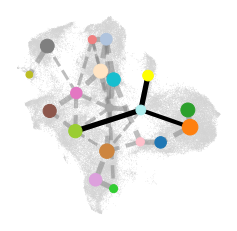

In [144]:
# PAGA plot for the paper
fig,ax=plt.subplots(figsize=(4,4))
sc.pl.embedding(adata_temp,'X_umap_opt',show=False,ax=ax)
sc.pl.paga(adata_temp, color='hc_gene_programs_parsed',threshold=thr,
           node_size_scale=1,layout='fa',edge_width_scale=0.7,
           labels=['']*adata_temp.obs['hc_gene_programs_parsed'].nunique(),
           dashed_edges='connectivities',solid_edges='connectivities_solid',
           #pos=adata_rn_b.uns['paga']['pos'],
           pos=pos.values,
           random_state=0, show=False,frameon=False,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig(path_fig+'paga_beta_CLfine_markedTransition_nolowQ.png',dpi=300,bbox_inches='tight')
#del adata_temp